In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine,Unit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('uber.csv')

In [22]:
df


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [23]:
df.shape


(200000, 9)

In [24]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
df.columns


Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [9]:
#Clean the Data

In [29]:
df = df.dropna(subset = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude','fare_amount'])

df = df[df['fare_amount'] > 0 ]

if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'] , errors = 'coerce')

df = df[(df['pickup_latitude'].between(-90, 90)) &
        (df['dropoff_latitude'].between(-90, 90)) &
        (df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_longitude'].between(-180, 180)) ]

df.shape


(199965, 9)

In [11]:
#Feature Engineering 

In [30]:
def distance(row):
    a = (row['pickup_latitude'], row['pickup_longitude'])
    b = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(a, b, unit=Unit.KILOMETERS)

df['distance_km'] = df.apply(distance, axis=1)

In [17]:
    !pip install haversine

In [47]:
#OUTLIER DETECTION


In [53]:
def remove_outlier(df,columns):
    df2 = df.copy()
    for col in columns:
        Q1 = df2[col].quantile(0.25)
        Q3 = df2[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        df2 = df2[(df2[col] >=low ) & (df2[col] <= high )]
    return df2

df_no_out = remove_outlier(df, ['distance_km', 'fare_amount'])
print('After IQR outlier removal', df_no_out.shape)
df = df_no_out.copy()

After IQR outlier removal (160552, 10)


In [59]:
#IDENTIFY OUTLIERS

In [55]:
df.columns


Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance_km'],
      dtype='object')

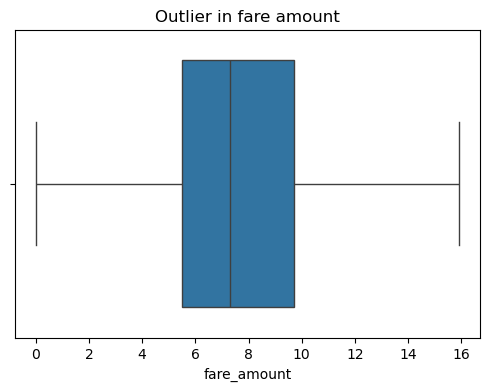

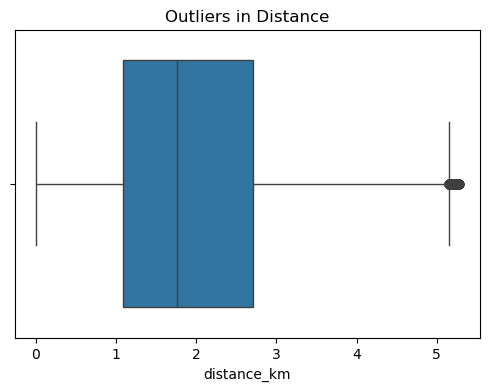

In [61]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['fare_amount'])
plt.title("Outlier in fare amount")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df['distance_km'])
plt.title("Outliers in Distance")
plt.show()

             fare_amount  distance_km
fare_amount     1.000000     0.728355
distance_km     0.728355     1.000000


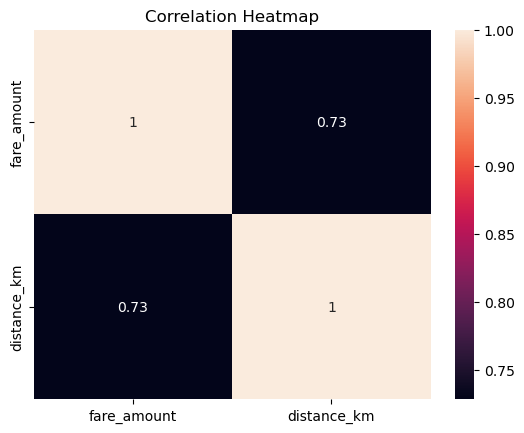

In [63]:
corr = df[['fare_amount','distance_km']].corr()
print(corr)

sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [69]:
X = df[['distance_km']]
Y = df['fare_amount']

In [70]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size= 0.2,random_state = 18)

In [71]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
y_pred_lr = lr.predict(X_test)

In [72]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)
y_pred_rf = rf.predict(X_test)

In [77]:
print("---- Linear Regression ----")
print("R2 Score:", r2_score(Y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred_lr)))

---- Linear Regression ----
R2 Score: 0.5272113914555374
RMSE: 1.9992342068983946


In [80]:
print("----Random Forest Regression ----")
print("R2 Score:", r2_score(Y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred_rf)))

----Random Forest Regression ----
R2 Score: 0.3996375827058891
RMSE: 2.2528740923152104
